In [2]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=5bade729e438d3d2d2457a9823fe418bae06ec7b168297339a539099f05b5322
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [3]:
from pyspark.sql import SparkSession

In [4]:
spark = SparkSession.builder.appName("LinearRegressionExample").getOrCreate()

In [5]:
data = spark.read.csv("/content/FOOD_DELIVERY_DATASET1.csv", header=True, inferSchema=True)

In [6]:
data.show()

+-------+------------------+-------------------+-----------------------+-------------------+--------------------+--------------------------+---------------------------+----------+-----------+-------------------+-----------------+--------------------+-----------------+-------------+-----------------+-------------------+--------+--------------+---------------+
|     ID|Delivery_person_ID|Delivery_person_Age|Delivery_person_Ratings|Restaurant_latitude|Restaurant_longitude|Delivery_location_latitude|Delivery_location_longitude|Order_Date|Time_Orderd|  Time_Order_picked|Weatherconditions|Road_traffic_density|Vehicle_condition|Type_of_order|  Type_of_vehicle|multiple_deliveries|Festival|          City|Time_taken(min)|
+-------+------------------+-------------------+-----------------------+-------------------+--------------------+--------------------------+---------------------------+----------+-----------+-------------------+-----------------+--------------------+-----------------+----------

In [7]:
data.columns

['ID',
 'Delivery_person_ID',
 'Delivery_person_Age',
 'Delivery_person_Ratings',
 'Restaurant_latitude',
 'Restaurant_longitude',
 'Delivery_location_latitude',
 'Delivery_location_longitude',
 'Order_Date',
 'Time_Orderd',
 'Time_Order_picked',
 'Weatherconditions',
 'Road_traffic_density',
 'Vehicle_condition',
 'Type_of_order',
 'Type_of_vehicle',
 'multiple_deliveries',
 'Festival',
 'City',
 'Time_taken(min)']

In [8]:
data.show(5)

+-------+------------------+-------------------+-----------------------+-------------------+--------------------+--------------------------+---------------------------+----------+-----------+-------------------+-----------------+--------------------+-----------------+-------------+---------------+-------------------+--------+--------------+---------------+
|     ID|Delivery_person_ID|Delivery_person_Age|Delivery_person_Ratings|Restaurant_latitude|Restaurant_longitude|Delivery_location_latitude|Delivery_location_longitude|Order_Date|Time_Orderd|  Time_Order_picked|Weatherconditions|Road_traffic_density|Vehicle_condition|Type_of_order|Type_of_vehicle|multiple_deliveries|Festival|          City|Time_taken(min)|
+-------+------------------+-------------------+-----------------------+-------------------+--------------------+--------------------------+---------------------------+----------+-----------+-------------------+-----------------+--------------------+-----------------+-------------+

In [9]:
data.describe().show()


+-------+-------+------------------+-------------------+-----------------------+-------------------+--------------------+--------------------------+---------------------------+----------+-----------+-----------------+--------------------+------------------+-------------+---------------+-------------------+--------+--------------+---------------+
|summary|     ID|Delivery_person_ID|Delivery_person_Age|Delivery_person_Ratings|Restaurant_latitude|Restaurant_longitude|Delivery_location_latitude|Delivery_location_longitude|Order_Date|Time_Orderd|Weatherconditions|Road_traffic_density| Vehicle_condition|Type_of_order|Type_of_vehicle|multiple_deliveries|Festival|          City|Time_taken(min)|
+-------+-------+------------------+-------------------+-----------------------+-------------------+--------------------+--------------------------+---------------------------+----------+-----------+-----------------+--------------------+------------------+-------------+---------------+-----------------

In [10]:
pip install xgboost

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statistics

from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

In [12]:
from pyspark.sql.functions import col

In [13]:
for column in data.columns:
    print(column)

ID
Delivery_person_ID
Delivery_person_Age
Delivery_person_Ratings
Restaurant_latitude
Restaurant_longitude
Delivery_location_latitude
Delivery_location_longitude
Order_Date
Time_Orderd
Time_Order_picked
Weatherconditions
Road_traffic_density
Vehicle_condition
Type_of_order
Type_of_vehicle
multiple_deliveries
Festival
City
Time_taken(min)


In [15]:
# Use groupBy and count to get the value counts for each column
column_counts = data.groupBy(column).count().orderBy(col("count").desc())

In [16]:
column_counts

DataFrame[Time_taken(min): string, count: bigint]

In [19]:
# Show the results
column_counts.show(truncate=False)
print("------------------------------------")


+---------------+-----+
|Time_taken(min)|count|
+---------------+-----+
|(min) 29       |531  |
|(min) 26       |527  |
|(min) 27       |518  |
|(min) 25       |504  |
|(min) 19       |479  |
|(min) 28       |478  |
|(min) 17       |443  |
|(min) 15       |436  |
|(min) 24       |429  |
|(min) 16       |419  |
|(min) 18       |411  |
|(min) 22       |405  |
|(min) 21       |399  |
|(min) 23       |389  |
|(min) 20       |383  |
|(min) 33       |295  |
|(min) 32       |290  |
|(min) 31       |289  |
|(min) 30       |287  |
|(min) 34       |287  |
+---------------+-----+
only showing top 20 rows

------------------------------------


In [21]:
def update_column_name(data):
    # Use withColumnRenamed to rename the column
    data = data.withColumnRenamed('Weatherconditions', 'Weather_conditions')
    return data

# Update the column names
data = update_column_name(data)

# Display the updated column names
print(data.columns)

['ID', 'Delivery_person_ID', 'Delivery_person_Age', 'Delivery_person_Ratings', 'Restaurant_latitude', 'Restaurant_longitude', 'Delivery_location_latitude', 'Delivery_location_longitude', 'Order_Date', 'Time_Orderd', 'Time_Order_picked', 'Weather_conditions', 'Road_traffic_density', 'Vehicle_condition', 'Type_of_order', 'Type_of_vehicle', 'multiple_deliveries', 'Festival', 'City', 'Time_taken(min)']


In [22]:

from pyspark.sql.functions import split, col

In [23]:
def extract_column_value(data):
    # Extract time and convert to int
    data = data.withColumn('Time_taken(min)', col('Time_taken(min)').substr(7, 2).cast('int'))

    # Extract Weather conditions
    data = data.withColumn('Weather_conditions', split(col('Weather_conditions'), ' ')[1])

    # Extract city code from Delivery person ID
    data = data.withColumn('City_code', split(col('Delivery_person_ID'), 'RES')[0])

    return data

# Extract values from relevant columns
data = extract_column_value(data)

# Display the relevant columns
data.select('Time_taken(min)', 'Weather_conditions', 'City_code').show()

+---------------+------------------+---------+
|Time_taken(min)|Weather_conditions|City_code|
+---------------+------------------+---------+
|             33|             Windy|     BANG|
|             26|            Stormy|      JAP|
|             21|               Fog|      JAP|
|             30|             Sunny|     CHEN|
|             26|               Fog|      GOA|
|             40|             Windy|     BANG|
|             32|             Windy|      KOL|
|             34|            Cloudy|      MYS|
|             46|               Fog|      HYD|
|             23|            Stormy|      KOC|
|             21|             Windy|      VAD|
|             20|             Sunny|   RANCHI|
|             41|             Windy|     BANG|
|             20|               Fog|   RANCHI|
|             33|            Cloudy|      HYD|
|             40|             Windy|    COIMB|
|             41|             Sunny|      HYD|
|             15|            Cloudy|     CHEN|
|            

In [24]:
def drop_columns(data, columns_to_drop):
    # Use drop method to drop specified columns
    data = data.drop(*columns_to_drop)
    return data

# Specify columns to drop
columns_to_drop = ['ID', 'Delivery_person_ID']

# Drop columns
data = drop_columns(data, columns_to_drop)

# Display the remaining columns
data.columns

['Delivery_person_Age',
 'Delivery_person_Ratings',
 'Restaurant_latitude',
 'Restaurant_longitude',
 'Delivery_location_latitude',
 'Delivery_location_longitude',
 'Order_Date',
 'Time_Orderd',
 'Time_Order_picked',
 'Weather_conditions',
 'Road_traffic_density',
 'Vehicle_condition',
 'Type_of_order',
 'Type_of_vehicle',
 'multiple_deliveries',
 'Festival',
 'City',
 'Time_taken(min)',
 'City_code']

In [26]:
def check_duplicates(data):
    # Use dropDuplicates to remove duplicate rows
    deduplicated_data = data.dropDuplicates()

    if deduplicated_data.count() < data.count():
        print("There are Duplicate values present")
    else:
        print("There is no duplicate value present")

# Check for duplicates
check_duplicates(data)



There is no duplicate value present


In [27]:
from pyspark.sql.types import FloatType, DateType

In [28]:
def update_datatype(data):
    # Update data types using PySpark functions
    data = data.withColumn('Delivery_person_Age', col('Delivery_person_Age').cast(FloatType()))
    data = data.withColumn('Delivery_person_Ratings', col('Delivery_person_Ratings').cast(FloatType()))
    data = data.withColumn('multiple_deliveries', col('multiple_deliveries').cast(FloatType()))
    data = data.withColumn('Order_Date', col('Order_Date').cast(DateType()))

    return data

# Update data types
data = update_datatype(data)

In [29]:
from pyspark.sql.functions import when
from pyspark.sql.types import StringType, FloatType

In [30]:
def convert_nan(data):
    # Replace 'NaN' with PySpark's null value for each column
    for column in data.columns:
        data = data.withColumn(column, when(col(column) == 'NaN', None).otherwise(col(column).cast(StringType())))

    # Cast relevant columns to the desired data type (e.g., FloatType)
    data = data.withColumn('Delivery_person_Age', col('Delivery_person_Age').cast(FloatType()))
    data = data.withColumn('Delivery_person_Ratings', col('Delivery_person_Ratings').cast(FloatType()))
    data = data.withColumn('multiple_deliveries', col('multiple_deliveries').cast(FloatType()))

    return data

# Convert 'NaN' to null values
data = convert_nan(data)


In [32]:
from pyspark.sql.functions import col, count


In [33]:
# Check null values for each column
null_counts = data.select([col(column).isNull().alias(column) for column in data.columns])

# Sum the null counts for each column
null_counts_per_column = null_counts.agg(*[count(col(column)).alias(column) for column in null_counts.columns])

# Display the null counts for each column
null_counts_per_column.show()

+-------------------+-----------------------+-------------------+--------------------+--------------------------+---------------------------+----------+-----------+-----------------+------------------+--------------------+-----------------+-------------+---------------+-------------------+--------+-----+---------------+---------+
|Delivery_person_Age|Delivery_person_Ratings|Restaurant_latitude|Restaurant_longitude|Delivery_location_latitude|Delivery_location_longitude|Order_Date|Time_Orderd|Time_Order_picked|Weather_conditions|Road_traffic_density|Vehicle_condition|Type_of_order|Type_of_vehicle|multiple_deliveries|Festival| City|Time_taken(min)|City_code|
+-------------------+-----------------------+-------------------+--------------------+--------------------------+---------------------------+----------+-----------+-----------------+------------------+--------------------+-----------------+-------------+---------------+-------------------+--------+-----+---------------+---------+
|   

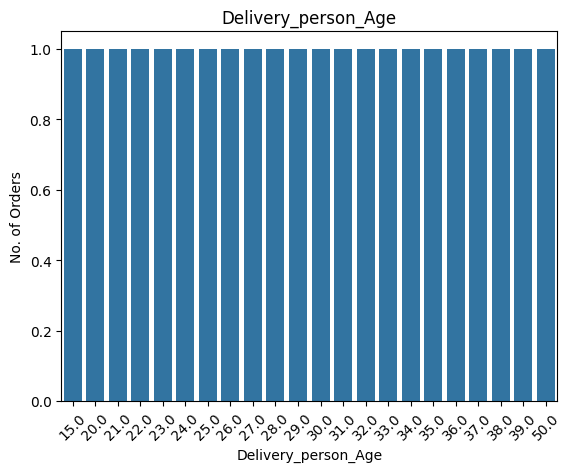

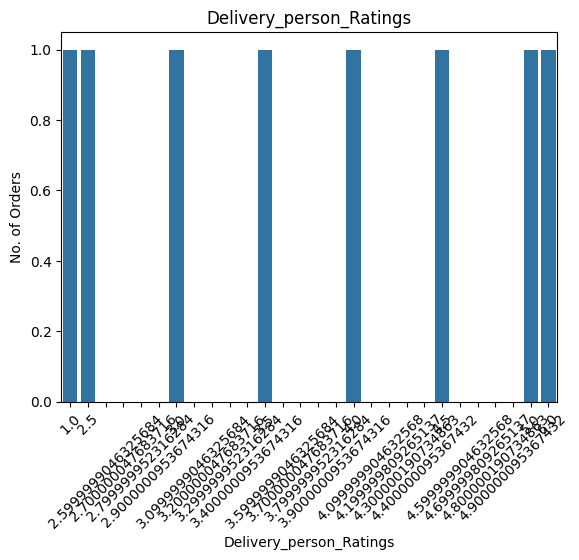

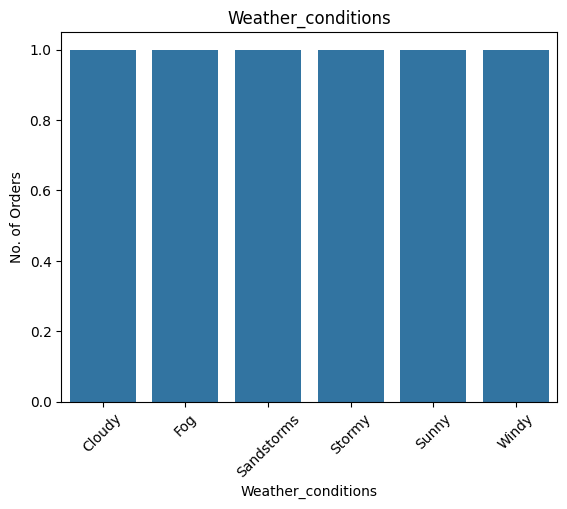

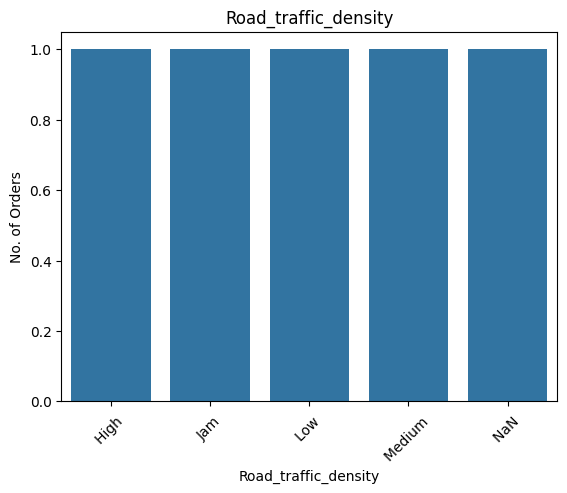

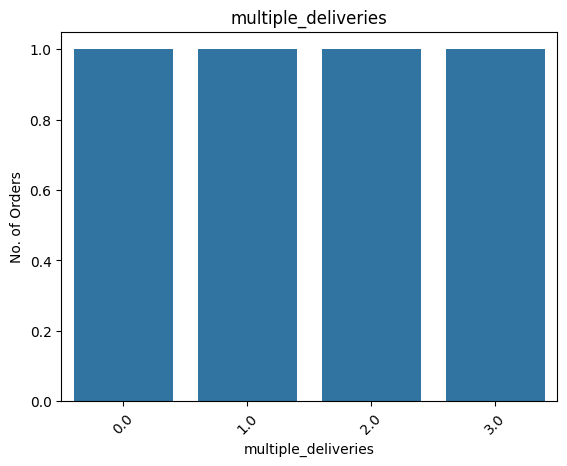

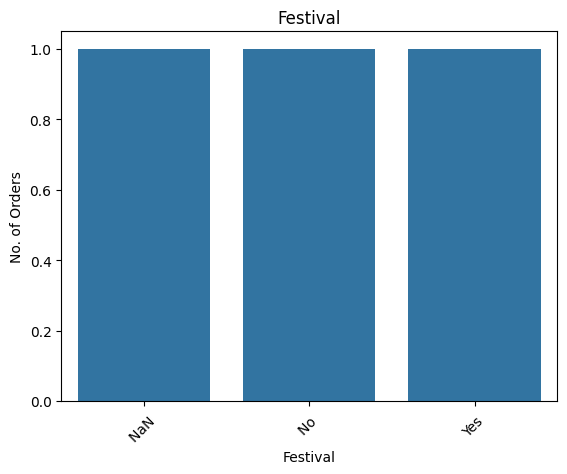

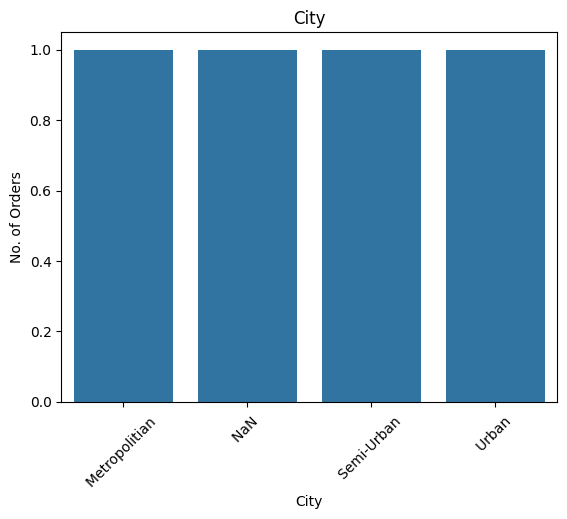

In [34]:
# List of columns to explore
cols = ['Delivery_person_Age', 'Delivery_person_Ratings', 'Weather_conditions', 'Road_traffic_density',
        'multiple_deliveries', 'Festival', 'City']

# Define a function to create count plots
def create_count_plot(column_name):
    data_for_plot = data.groupBy(column_name).count().toPandas()
    sns.countplot(data=data_for_plot, x=column_name,
                  order=data_for_plot[column_name].value_counts().sort_index().index)
    plt.xlabel(column_name)
    plt.ylabel('No. of Orders')
    plt.title(column_name)
    plt.xticks(rotation=45)
    plt.show()

# Create count plots for each column
for column_name in cols:
    create_count_plot(column_name)

In [35]:
def handle_null_values(df):
    # Handling null values at the DataFrame level
    df = df.na.fill({
        'Delivery_person_Age': df.approxQuantile('Delivery_person_Age', [0.5], 0.01)[0],
        'Weather_conditions': 'Unknown',  # Replace with an appropriate default value
        'City': df.groupBy('City').count().orderBy(col('count').desc()).first()['City'],
        'Festival': df.groupBy('Festival').count().orderBy(col('count').desc()).first()['Festival'],
        'multiple_deliveries': df.groupBy('multiple_deliveries').count().orderBy(col('count').desc()).first()['multiple_deliveries'],
        'Road_traffic_density': df.groupBy('Road_traffic_density').count().orderBy(col('count').desc()).first()['Road_traffic_density'],
        'Delivery_person_Ratings': df.approxQuantile('Delivery_person_Ratings', [0.5], 0.01)[0]
    })

    return df

In [36]:
# Handle null values
data = handle_null_values(data)

# Check for null values after handling
data.select([col(column).isNull().alias(column) for column in data.columns]).show()

+-------------------+-----------------------+-------------------+--------------------+--------------------------+---------------------------+----------+-----------+-----------------+------------------+--------------------+-----------------+-------------+---------------+-------------------+--------+-----+---------------+---------+
|Delivery_person_Age|Delivery_person_Ratings|Restaurant_latitude|Restaurant_longitude|Delivery_location_latitude|Delivery_location_longitude|Order_Date|Time_Orderd|Time_Order_picked|Weather_conditions|Road_traffic_density|Vehicle_condition|Type_of_order|Type_of_vehicle|multiple_deliveries|Festival| City|Time_taken(min)|City_code|
+-------------------+-----------------------+-------------------+--------------------+--------------------------+---------------------------+----------+-----------+-----------------+------------------+--------------------+-----------------+-------------+---------------+-------------------+--------+-----+---------------+---------+
|   

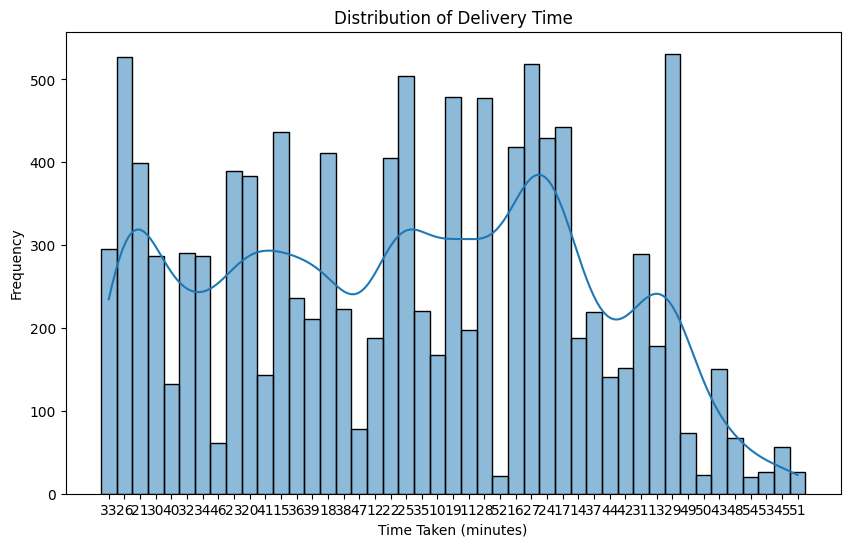

In [37]:
# Convert the target column to a Pandas DataFrame
target_data = data.select('Time_taken(min)').toPandas()

# Plotting
plt.figure(figsize=(10, 6))
sns.histplot(target_data['Time_taken(min)'], bins=30, kde=True)
plt.title('Distribution of Delivery Time')
plt.xlabel('Time Taken (minutes)')
plt.ylabel('Frequency')
plt.show()

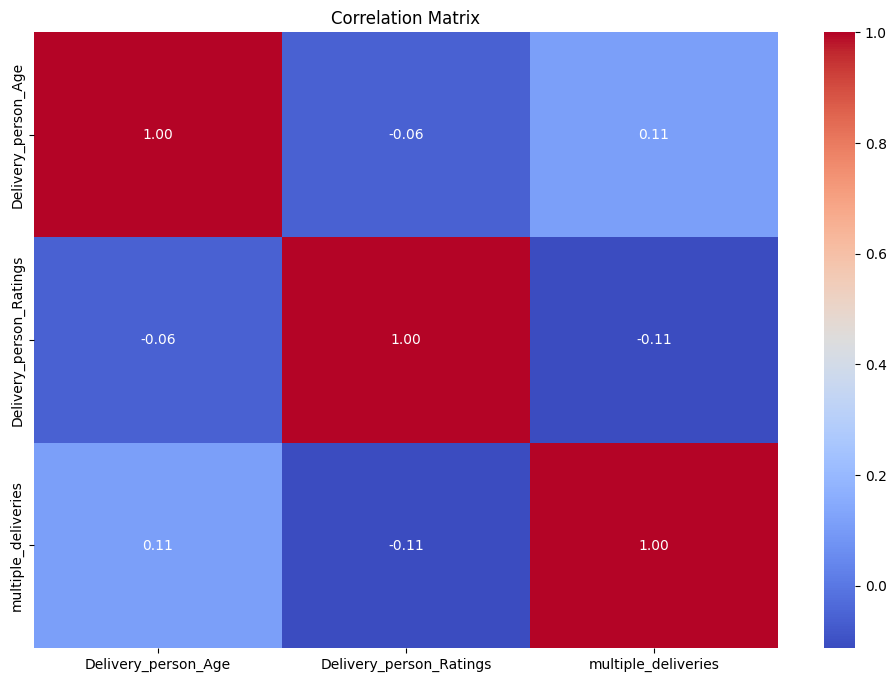

In [38]:
correlation_matrix = data.toPandas().corr()

# Plotting
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

DoubleType()


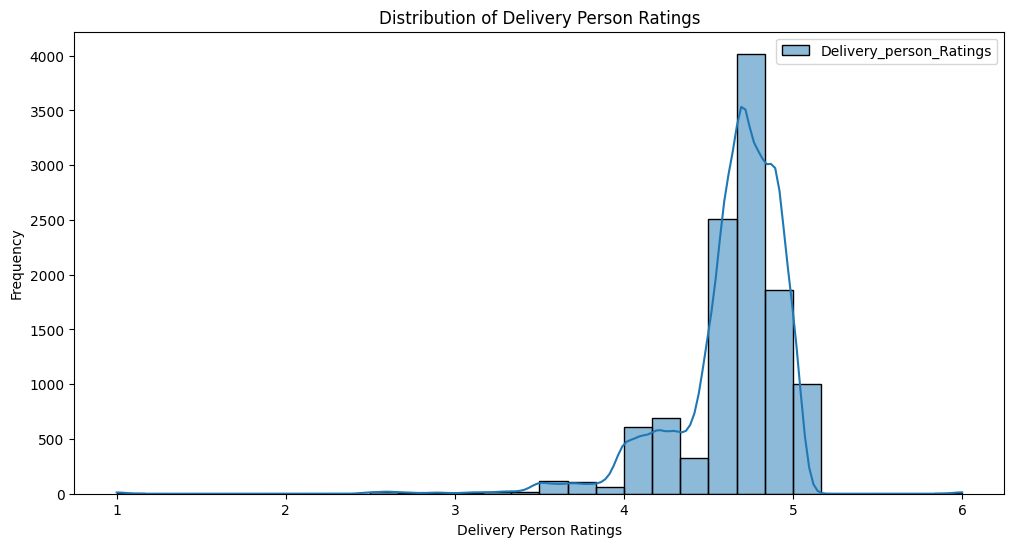

In [44]:
# Check the data type of 'Delivery_person_Ratings'
print(data.schema['Delivery_person_Ratings'].dataType)

# If the data type is not numeric, you may need to cast it to a numeric type
data = data.withColumn('Delivery_person_Ratings', data['Delivery_person_Ratings'].cast('double'))

# Plotting the distribution
plt.figure(figsize=(12, 6))
sns.histplot(data.select('Delivery_person_Ratings').toPandas(), bins=30, kde=True)
plt.title('Distribution of Delivery Person Ratings')
plt.xlabel('Delivery Person Ratings')
plt.ylabel('Frequency')
plt.show()

In [45]:
import plotly.express as px
delivery_data_pandas = data.toPandas()

# Plotting the delivery location distribution on a map
fig3 = px.scatter_geo(delivery_data_pandas,
                      lat='Delivery_location_latitude', lon='Delivery_location_longitude',
                      title='Delivery Location Distribution on Map')
fig3.show()

In [46]:
import plotly.graph_objects as go
delivery_data_pandas = data.toPandas()

# Plotting the box plot for Time Taken by Vehicle Type
fig4 = go.Figure()
fig4.add_trace(go.Box(x=delivery_data_pandas['Type_of_vehicle'], y=delivery_data_pandas['Time_taken(min)'],
                      boxpoints='all', jitter=0.3, pointpos=-1.8, name='Time Taken by Vehicle Type'))
fig4.update_layout(title='Box Plot for Time Taken by Vehicle Type',
                   xaxis_title='Type of Vehicle',
                   yaxis_title='Time Taken (minutes)')
fig4.show()

In [48]:
from pyspark.sql.functions import col, dayofmonth, month, quarter, year, dayofweek, when
from pyspark.sql.types import IntegerType

In [49]:
# Convert 'Order_Date' to PySpark DateType
data = data.withColumn("Order_Date", data["Order_Date"].cast("date"))

# Extract date features
data = (
            data
    .withColumn("day", dayofmonth(col("Order_Date")))
    .withColumn("month", month(col("Order_Date")))
    .withColumn("quarter", quarter(col("Order_Date")))
    .withColumn("year", year(col("Order_Date")))
    .withColumn("day_of_week", dayofweek(col("Order_Date")).cast(IntegerType()))
    .withColumn("is_weekend", when(dayofweek(col("Order_Date")).isin([6, 7]), 1).otherwise(0).cast(IntegerType()))
)

# Show the updated DataFrame
data.show()

+-------------------+-----------------------+-------------------+--------------------+--------------------------+---------------------------+----------+-----------+-------------------+------------------+--------------------+-----------------+-------------+-----------------+-------------------+--------+--------------+---------------+---------+----+-----+-------+----+-----------+----------+
|Delivery_person_Age|Delivery_person_Ratings|Restaurant_latitude|Restaurant_longitude|Delivery_location_latitude|Delivery_location_longitude|Order_Date|Time_Orderd|  Time_Order_picked|Weather_conditions|Road_traffic_density|Vehicle_condition|Type_of_order|  Type_of_vehicle|multiple_deliveries|Festival|          City|Time_taken(min)|City_code| day|month|quarter|year|day_of_week|is_weekend|
+-------------------+-----------------------+-------------------+--------------------+--------------------------+---------------------------+----------+-----------+-------------------+------------------+-------------